In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import math

import seaborn as sns
sns.set(style="ticks", color_codes=True)

In [24]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

In [26]:
np.sqrt(mean_squared_error([5.], [2.5]))

2.5

### Error function

The assesment for this competition is the root-mean-squared error. So, the assesment score will be a float output. An example can be shown below for how you should expect to see the output. Note that the lower the score, the better!

In [27]:
example_y = torch.tensor([1., 0., 1.])
example_pred = torch.tensor([0.8, 0.1, 1.])
torch.sqrt(torch.nn.MSELoss()(example_y, example_pred))

tensor(0.1291)

To get the data for this, you should visit the kaggle competition page:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [4]:
train_set = pd.read_csv("train.csv")
train_set.set_index("Id", inplace=True)
train_set = train_set[train_set['GrLivArea'] < 4000]

test_set_x = pd.read_csv("test.csv")
test_set_x.set_index("Id", inplace=True)

test_set_y = pd.read_csv("sample_submission.csv")
test_set_y.set_index("Id", inplace=True)

### Correlation with target

We can see below that there are a number of variables with a high correlation to the target variable (Sale Price). We want these to stand out, so we can engineer new features from them.

In [7]:
most_corr = train_set.corr()['SalePrice'].sort_values(ascending=False)

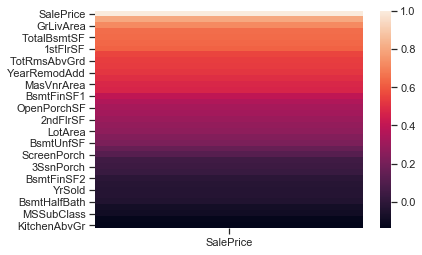

In [11]:
sns.heatmap(pd.DataFrame(most_corr))

In [ ]:
most_corr_cols = most_corr.index[1:11]

In [127]:
### expand top correlated features ###
for col in most_corr_cols:
    train_set[col + "_2"] = train_set[col]**2
    test_set_x[col + "_2"] = test_set_x[col]**2
    

    train_set[col + "_3"] = train_set[col]**3
    test_set_x[col + "_3"] = test_set_x[col]**2
    
    train_set[col + '_sqrt'] = np.sqrt(train_set[col])
    test_set_x[col + '_sqrt'] = np.sqrt(test_set_x[col])

In [128]:
engin_feat_cols_2 = [i + "_2" for i in most_corr]
engin_feat_cols_3 = [i + "_3" for i in most_corr]
engin_feat_cols_sqrt = [i + "_sqrt" for i in most_corr]

all_engin_cols = engin_feat_cols_2 + engin_feat_cols_3 + engin_feat_cols_sqrt

### Fill in missing data

From looking at the data, there are a number of columns with problems in them, the biggest one being null data. Each column needs to be treated differently. For example, there are some where it makes sense to just fill with 0 or "None", but there are others (Electrical, for example) where we can use the common values in the column as a placeholder.

It might be possible to use features correlated with these columns in order to impute values, or use an sklearn imputer. For now, they can just be filled in based on best judgement from surrounding data.

There are a few cases where there are missing values in the test set that aren't in the training set. These need to be handled as well and are the only case where the test set data is used/altered.

In [129]:
train_set.select_dtypes(exclude="object")
all_data_na = (train_set.isnull().sum()/len(train_set)) * 100
cols_with_null = all_data_na[all_data_na > 0].index

In [130]:
train_set[cols_with_null].head()

,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
Id,,,,,,,,,,,,,,,,,,,
1,65.0,NaN,BrkFace,196.0,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,2003.0,RFn,TA,TA,NaN,NaN,NaN
2,80.0,NaN,None,0.0,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Attchd,1976.0,RFn,TA,TA,NaN,NaN,NaN
3,68.0,NaN,BrkFace,162.0,Gd,TA,Mn,GLQ,Unf,SBrkr,TA,Attchd,2001.0,RFn,TA,TA,NaN,NaN,NaN
4,60.0,NaN,None,0.0,TA,Gd,No,ALQ,Unf,SBrkr,Gd,Detchd,1998.0,Unf,TA,TA,NaN,NaN,NaN
5,84.0,NaN,BrkFace,350.0,Gd,TA,Av,GLQ,Unf,SBrkr,TA,Attchd,2000.0,RFn,TA,TA,NaN,NaN,NaN


In [131]:
repl_none = [
    "Alley",
    "MasVnrType",
    "BsmtCond",
    "BsmtExposure",
    "BsmtQual",
    "BsmtFinType2",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "PoolQC",
    "Fence",
    "MiscFeature",
    "BsmtFinType1"
]

train_set[repl_none] = train_set[repl_none].fillna("None")

### Overwhelming amount are SBrkr in here, presume this one is, can remove record later to see if helps accuracy
train_set["Electrical"].fillna("SBrkr", inplace=True)

test_set_x[repl_none] = test_set_x[repl_none].fillna("None")

test_set_x["Electrical"].fillna("SBrkr", inplace=True)

In [132]:
# train_set.select_dtypes(exclude="object")
all_data_na = (train_set.isnull().sum()/len(train_set)) * 100
cols_with_null = all_data_na[all_data_na > 0].index
train_set[cols_with_null].head()

,LotFrontage,MasVnrArea,GarageYrBlt
Id,,,
1,65.0,196.0,2003.0
2,80.0,0.0,1976.0
3,68.0,162.0,2001.0
4,60.0,0.0,1998.0
5,84.0,350.0,2000.0


In [133]:
train_set['LotFrontage_null'] = train_set['LotFrontage'].isnull().astype(int)
test_set_x['LotFrontage_null'] = test_set_x['LotFrontage'].isnull().astype(int)
lot_front_median = train_set['LotFrontage'].median()

train_set['LotFrontage'].fillna(lot_front_median, inplace=True)
test_set_x['LotFrontage'].fillna(lot_front_median, inplace=True)

train_set["MasVnrArea"].fillna(0, inplace=True)
test_set_x["MasVnrArea"].fillna(0, inplace=True)

In [134]:
#### Test set specific

test_set_x['MSZoning'].fillna("RL", inplace=True) ### Majority RL, but can edit this after
test_set_x['Utilities'].fillna("AllPub", inplace=True) ### All but one in traning are AllPub, just presume it's this

#### TRY PUT THIS THROUGH ITS OWN MODEL TO DETERMINE - BASE ON CORR ####
test_set_x['Exterior1st'].fillna("Wd Sdng", inplace=True) ##Take this for the neighbourhood
test_set_x['Exterior2nd'].fillna("Wd Sdng", inplace=True)

test_set_x["BsmtFinSF1"].fillna(0, inplace=True)
test_set_x["BsmtFinSF2"].fillna(0, inplace=True)
test_set_x["BsmtUnfSF"].fillna(0, inplace=True)
test_set_x["TotalBsmtSF"].fillna(0, inplace=True)
test_set_x["BsmtFullBath"].fillna(0, inplace=True)
test_set_x["BsmtHalfBath"].fillna(0, inplace=True)

test_set_x['KitchenQual'].fillna("TA", inplace=True)
test_set_x['Functional'].fillna("Typ", inplace=True)

test_set_x["GarageCars"].fillna(0, inplace=True)
test_set_x["GarageArea"].fillna(0, inplace=True)

test_set_x['SaleType'].fillna("WD", inplace=True)

The GarageYrBlt is a bit different, as it is hard to just impute values for a year. It doesn't correlate that high with the taret variable, so we can just drop it for now.

In [135]:
### DROP FOR NOW! ###
train_set.drop(["GarageYrBlt"], axis=1, inplace=True)
test_set_x.drop(["GarageYrBlt"], axis=1, inplace=True)

### Scale and encode

It's time to scale and encode the variables so they are ready to put into the model. The list below can be seen of which features needs to scaled and encoded.

We can store all the encoders and scalers in dictionaries so we can always refer back to them. The key will be the column name, so they'll be easy to access.

Remember, it is important that scaling and encoding is only done on the **training set only**. This applies mainly to scaling, as using the values in test set compromises a model.

In [136]:
#### SCALE AND ENCODE ####

scale_cols = [
    "LotFrontage",
    "LotArea",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "YearBuilt",
    "YearRemodAdd",
    "MSSubClass",
    "YrSold"
]

scale_cols = scale_cols + all_engin_cols
cat_cols = [
    "MSZoning",
    "Street",
    "Alley",
    "LotShape",
    "LandContour",
    "Utilities",
    "LotConfig",
    "LandSlope",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "ExterQual",
    "ExterCond",
    "Foundation",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Heating",
    "HeatingQC",
    "CentralAir",
    "Electrical",
    "KitchenQual",
    "Functional",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "PavedDrive",
    "PoolQC",
    "Fence",
    "MiscFeature",
    "SaleType",
    "SaleCondition",   
]

In [137]:
### TRAIN SCALE AND CATS ###
scaler_lookup = {}
for col in scale_cols:
#     scaler = StandardScaler()
    scaler = RobustScaler()
    train_set[col] = scaler.fit_transform(train_set[col].values.reshape(-1, 1))
    scaler_lookup[col] = scaler

    test_set_x[col] = scaler.transform(test_set_x[col].values.reshape(-1, 1))

In [138]:
encoder_lookup = {}
for col in cat_cols:
    if train_set_x[col].dtype != "int64":
        encoder = LabelEncoder()
        unique_classes = train_set[col].unique()
        if not "None" in unique_classes:
            unique_classes = np.concatenate((unique_classes, np.array(["None"])))
        labelled_col = encoder.fit(unique_classes.reshape(-1, 1))
        train_set[col] = encoder.transform(train_set[col].values.reshape(-1, 1))
        encoder_lookup[col] = encoder

        test_set_x[col] = encoder.transform(test_set_x[col].values.reshape(-1, 1))

C:\Users\rob.mccluskey\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rob.mccluskey\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### What new data looks like

Below you can see the data with everything encoded and scaled. It's ready to be put into a model!

In [139]:
train_set.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,TotRmsAbvGrd_2,TotRmsAbvGrd_3,TotRmsAbvGrd_sqrt,YearBuilt_2,YearBuilt_3,YearBuilt_sqrt,YearRemodAdd_2,YearRemodAdd_3,YearRemodAdd_sqrt,LotFrontage_null
Id,,,,,,,,,,,,,,,,,,,,,
1,0.2,4,-0.210526,-0.251528,2,1,4,3,0,4,...,1.166667,1.357798,0.924952,0.677492,0.681074,0.672124,0.256686,0.258342,0.254209,0
2,-0.6,4,0.578947,0.032475,2,1,4,3,0,2,...,0.000000,0.000000,0.000000,0.086825,0.086689,0.087021,-0.469653,-0.469497,-0.469867,0
3,0.2,4,-0.052632,0.439958,2,1,0,3,0,4,...,0.000000,0.000000,0.000000,0.633464,0.636491,0.628919,0.229609,0.231032,0.227478,0
4,0.4,4,-0.473684,0.020127,2,1,0,3,0,0,...,0.541667,0.582569,0.479057,-1.218134,-1.197524,-1.249777,-0.629723,-0.628565,-0.631444,0
5,0.2,4,0.789474,1.183306,2,1,0,3,0,2,...,1.875000,2.353211,1.343746,0.611467,0.614233,0.607308,0.175495,0.176494,0.173998,0


In [143]:
train_set_x = train_set.drop(["SalePrice"], axis=1)
train_set_y = train_set['SalePrice']

### Minmax scale the target variable

This is for the sake of the error score, as the output variable is extremely large. In order to make it better understandable when comparing to the leaderboard, we'll scale the target.

In [176]:
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(train_set_y.values.reshape(-1, 1))

C:\Users\rob.mccluskey\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### Model

Below is the model, it's a simple feed-forward where the final layer is just a linear computation.

In [28]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden1 = nn.Linear(109, 50)  # equivalent to Dense in keras
        self.hidden2 = nn.Dropout(0.4)
        self.hidden3 = nn.Linear(50, 30)  # equivalent to Dense in keras
        self.hidden4 = nn.Dropout(0.2)
        self.hidden5 = nn.Linear(30, 15)  # equivalent to Dense in keras
        self.hidden6 = nn.Dropout(0.2)
        self.hidden7 = nn.Linear(15, 1)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.hidden2(x)
        x = F.relu(self.hidden3(x))
        x = self.hidden4(x)
        x = F.relu(self.hidden5(x))
        x = self.hidden6(x)
        x = self.hidden7(x)
        return x

### Calculating error in the output

Below we run through 1000 epochs, at each point getting the loss. We store these in a list so we can view loss over time.

In [181]:
model = NeuralNet()
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)

In [182]:
from torch.autograd import Variable
losses = []
for epoch in range(1000):
    # Converting inputs and labels to Variable - put on gpu for speed
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(train_set_x.values).cuda().float())
        labels = Variable(torch.from_numpy(y_scaled).cuda().float())

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = torch.sqrt(criterion(outputs, labels))
    losses.append(loss)
    print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

tensor(3.7137, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 0, loss 3.7137296199798584
tensor(3.5413, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 1, loss 3.541271686553955
tensor(4.1546, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 2, loss 4.154598712921143
tensor(2.7615, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 3, loss 2.7615087032318115
tensor(1.7030, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 4, loss 1.7030470371246338
tensor(1.3613, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 5, loss 1.3612911701202393
tensor(1.3866, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 6, loss 1.3865574598312378
tensor(0.8416, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 7, loss 0.8416183590888977
tensor(2.5815, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 8, loss 2.581481456756592
tensor(1.0389, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 9, loss 1.0389230251312256
tensor(1.4362, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 10, loss 1.4361882209777832
tensor(1.6120, device='

epoch 97, loss 0.18812856078147888
tensor(0.4090, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 98, loss 0.4089547097682953
tensor(0.1460, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 99, loss 0.1459534913301468
tensor(0.1770, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 100, loss 0.17698344588279724
tensor(0.1620, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 101, loss 0.1620054394006729
tensor(0.1223, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 102, loss 0.12227211892604828
tensor(0.1989, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 103, loss 0.19885215163230896
tensor(0.1666, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 104, loss 0.16656866669654846
tensor(0.1343, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 105, loss 0.13431082665920258
tensor(0.3203, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 106, loss 0.3202732503414154
tensor(0.1681, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 107, loss 0.16806961596012115
tensor(0.2123, device='cuda:0', grad_fn=<SqrtBackwa

tensor(0.0854, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 192, loss 0.08538992702960968
tensor(0.0878, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 193, loss 0.08776208013296127
tensor(0.1045, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 194, loss 0.10446714609861374
tensor(0.1566, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 195, loss 0.15655136108398438
tensor(0.0858, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 196, loss 0.08577162772417068
tensor(0.0972, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 197, loss 0.0972430408000946
tensor(0.0871, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 198, loss 0.08712630718946457
tensor(0.1005, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 199, loss 0.10047942399978638
tensor(0.1151, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 200, loss 0.1151064857840538
tensor(0.0917, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 201, loss 0.09169966727495193
tensor(0.2703, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 202, loss 0.27025067

tensor(0.0969, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 288, loss 0.09691433608531952
tensor(0.0745, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 289, loss 0.07445250451564789
tensor(0.0765, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 290, loss 0.07649480551481247
tensor(0.0756, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 291, loss 0.07564979791641235
tensor(0.0835, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 292, loss 0.0835024043917656
tensor(0.0705, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 293, loss 0.0704936757683754
tensor(0.0868, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 294, loss 0.08680389821529388
tensor(0.0786, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 295, loss 0.07860997319221497
tensor(0.0708, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 296, loss 0.0707884281873703
tensor(0.0714, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 297, loss 0.07139689475297928
tensor(0.0768, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 298, loss 0.076809376

tensor(0.0786, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 384, loss 0.07863128185272217
tensor(0.0760, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 385, loss 0.07601042836904526
tensor(0.0758, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 386, loss 0.07581080496311188
tensor(0.0739, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 387, loss 0.07392299920320511
tensor(0.0760, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 388, loss 0.07603803277015686
tensor(0.0871, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 389, loss 0.0870717242360115
tensor(0.0666, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 390, loss 0.0665879175066948
tensor(0.0698, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 391, loss 0.06977900862693787
tensor(0.0716, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 392, loss 0.0715608224272728
tensor(0.0700, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 393, loss 0.06996435672044754
tensor(0.0671, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 394, loss 0.067114107

tensor(0.0655, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 482, loss 0.06550116091966629
tensor(0.0791, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 483, loss 0.0791429802775383
tensor(0.0673, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 484, loss 0.06726894527673721
tensor(0.0664, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 485, loss 0.06637617200613022
tensor(0.0646, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 486, loss 0.06464345008134842
tensor(0.2892, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 487, loss 0.28924980759620667
tensor(0.0790, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 488, loss 0.07900974154472351
tensor(0.0705, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 489, loss 0.07050317525863647
tensor(0.0678, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 490, loss 0.06776344031095505
tensor(0.0655, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 491, loss 0.06546323001384735
tensor(0.0661, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 492, loss 0.0660616

tensor(0.0654, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 579, loss 0.06535164266824722
tensor(0.0672, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 580, loss 0.0671677365899086
tensor(0.0641, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 581, loss 0.06407725811004639
tensor(0.0792, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 582, loss 0.0792158916592598
tensor(0.0618, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 583, loss 0.06183196231722832
tensor(0.0623, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 584, loss 0.06233420595526695
tensor(0.0602, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 585, loss 0.06019489839673042
tensor(0.0629, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 586, loss 0.06287720054388046
tensor(0.0589, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 587, loss 0.05894649028778076
tensor(0.0611, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 588, loss 0.06111874058842659
tensor(0.1106, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 589, loss 0.11064720

tensor(0.0618, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 672, loss 0.061809808015823364
tensor(0.0597, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 673, loss 0.059729766100645065
tensor(0.0635, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 674, loss 0.06350258737802505
tensor(0.0632, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 675, loss 0.06324772536754608
tensor(0.0629, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 676, loss 0.06289359927177429
tensor(0.0598, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 677, loss 0.059799667447805405
tensor(0.0628, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 678, loss 0.06283008307218552
tensor(0.0650, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 679, loss 0.06497148424386978
tensor(0.0614, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 680, loss 0.06139208376407623
tensor(0.0582, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 681, loss 0.05815434083342552
tensor(0.0629, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 682, loss 0.062

epoch 769, loss 0.05844235420227051
tensor(0.0550, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 770, loss 0.054993629455566406
tensor(0.0903, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 771, loss 0.09033507108688354
tensor(0.0570, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 772, loss 0.05703919380903244
tensor(0.0596, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 773, loss 0.059561774134635925
tensor(0.0593, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 774, loss 0.05932845547795296
tensor(0.0559, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 775, loss 0.0558774508535862
tensor(0.0601, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 776, loss 0.060096289962530136
tensor(0.0607, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 777, loss 0.06065943464636803
tensor(0.0634, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 778, loss 0.06340757757425308
tensor(0.0606, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 779, loss 0.06064116582274437
tensor(0.0600, device='cuda:0', grad_fn=<S

tensor(0.0582, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 866, loss 0.05815568566322327
tensor(0.0570, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 867, loss 0.05697937309741974
tensor(0.0591, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 868, loss 0.05914425477385521
tensor(0.0561, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 869, loss 0.056137748062610626
tensor(0.0604, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 870, loss 0.06044668331742287
tensor(0.0568, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 871, loss 0.05684912949800491
tensor(0.0563, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 872, loss 0.05625806003808975
tensor(0.0594, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 873, loss 0.059374041855335236
tensor(0.0575, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 874, loss 0.05748908221721649
tensor(0.0579, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 875, loss 0.05793299525976181
tensor(0.0606, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 876, loss 0.0606

epoch 962, loss 0.05789940059185028
tensor(0.0582, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 963, loss 0.05822347477078438
tensor(0.0565, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 964, loss 0.056476790457963943
tensor(0.0743, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 965, loss 0.07433114945888519
tensor(0.0561, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 966, loss 0.05605176463723183
tensor(0.0540, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 967, loss 0.05401972308754921
tensor(0.0595, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 968, loss 0.05953603237867355
tensor(0.0595, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 969, loss 0.059460971504449844
tensor(0.0588, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 970, loss 0.05876760929822922
tensor(0.0586, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 971, loss 0.05859880894422531
tensor(0.0575, device='cuda:0', grad_fn=<SqrtBackward>)
epoch 972, loss 0.0574791245162487
tensor(0.0713, device='cuda:0', grad_fn=<Sq

### Post-train

We see that the model converges fairly quickly, although we do get the odd spike in loss across the data. There could be any number of reasons for this, but it is best to look at this after our initial run.

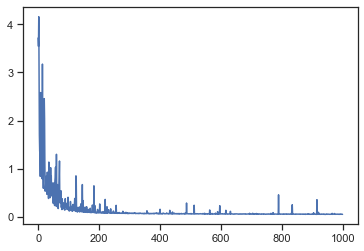

In [183]:
plt.plot(losses)

### Predictions and model loss on test data

Firstly, we look at how the model managed to fit in training. We can see it started to learn the pattern somewhat reasonably, although we still have some outliers.

We then use our test set to get our score. We get a loss of 0.1073, which is actually fairly decent! At the time of writing (6th August 2019), this would put the model at 160th out of 4271 entries! So we're inside the top 4%, which isn't bad for a first go.

We can see from the test set scatter that there isn't exactly a great deal of correlation, but this is where things can be tuned further. In particular, we can see that the training set appears to have a lot more houses that are valued higher than the test set, and this is something that can be taken into consideration for the future.

In [184]:
preds = y_scaler.inverse_transform(outputs.cpu().detach().numpy())

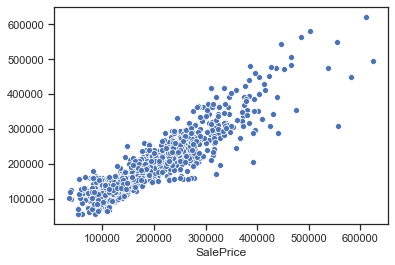

In [185]:
sns.scatterplot(train_set_y, preds.reshape(outputs.shape[0],))

In [195]:
y_test_scaled = y_scaler.transform(test_set_y['SalePrice'].values.reshape(-1, 1))
with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(test_set_x.fillna(0).values).cuda().float())
        labels = Variable(torch.from_numpy(y_test_scaled).cuda().float())
        
    test_preds = model(inputs)
    test_loss = torch.sqrt(criterion(test_preds, labels))
    print("Loss = ", test_loss)

Loss =  tensor(0.1073, device='cuda:0')


In [196]:
rescaled_test_preds = y_scaler.inverse_transform(test_preds.cpu()).reshape(test_preds.shape[0],)

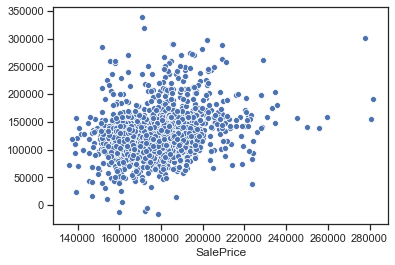

In [197]:
sns.scatterplot(test_set_y['SalePrice'],rescaled_test_preds)

### Future improvements

- **Use mini-batches**: Mini-batches should be used to generalise the model a lot better, it may help a lot with the spikes we see in the loss over time.
- **Further feature engineer**: We can try add new features. For example, adding in stuff like encodings for the century and decade could help the model.